# DCGANs

DCGAN means a GAN that uses the convolutional and convolutional-transpose layers in the descriminator and generator models respectively  
1. **Descriminator**: is composed of conv2d, batch normalization layers and uses the LeakyReLU activation with 0.2 as slope. it's input is a 3 x 64 x 64 images and the output is the proba that this image is real (it belongs to the real data distribution) 
2. **Generator** : for the gen, it uses convolutional-transpose and batch normalization layer, with the ReLU activation,the input is a latent vector z and the output is an 3 x 64 x 64  image ( The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image)

The Transformed Conv is almost doing the deconvolutional operation , but it doesn't create exctly the inverse results of the convolutional operation

## Import the used packages

In [130]:
from __future__ import print_function
import argparse
import os
import random
import torch as th
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image 


import cv2


We will define some inputs to have with them in all the notebook 

In [2]:


DATA_PATH = '../input/celeba-dataset/img_align_celeba/img_align_celeba'
# number of worker threads for loading the data 
N_WORKERS =  4
# in the DCGAN paper, they used a batch_size of 128 
batch_size = 128
#in this notebook we will use an images of 3 x 64 x 64 (if we desire to change it, we need to changes also in the gen and des architectures)
image_size =64 
nc = 3 # the number of channels (3 for the RGB images)
nz = 100 # length of the latent vector 
ngf = 64 # the depth of the feature maps in  the genegator 
ndf =  64 # the depth of the feature maps in the descriminator 

EPOCHS = 50
lr = 0.0002 # the learning rate for the optimizer (we choose 0.0002 relatively to the paper of the DCGAN)
beta1 = 0.5  # the hyperparameter for the adam optim


We are using the ImageFolder class to extract our data and doing some transformation on it 

we are resizing all the images to the appropriate size that we define earlier and cropping the image on the center, then normalizing it with mean and std

In [3]:
dataset = dset.ImageFolder(root="../input/celeba-dataset/img_align_celeba",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [4]:
# creating the dataloader based on the dataset 
# dl = th.utils.data.DataLoader(dataset,batch_size = batch_size , shuffle = True,num_workers = N_WORKERS)

# As the dataset is very large more then 200k intances we are going to use just 50k instances 
n_intances = 10000
indices = np.random.permutation(n_intances)
sampler = SubsetRandomSampler(indices)
dl = th.utils.data.DataLoader(dataset , batch_size  , sampler=sampler)


In [5]:
# setting the default device 
device = th.device("cuda" if th.cuda.is_available() else 'cpu')

In [6]:
#creating a helper fonction to show some real images samples 
def show_batch(dl): 
    for images, _ in dl : 
        fig, ax = plt.subplots(figsize = (16,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:20],10).permute(1,2,0))
        break

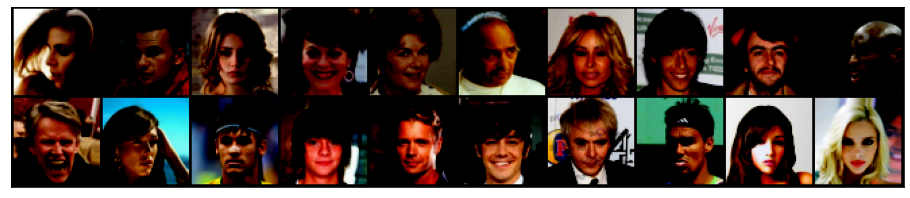

In [7]:
#plotting some samples 
show_batch(dl)

For the initialization of the model, we are going to use a random weights and bias from the Normale Distribution with mean=0 and std = 0.02 as specified in the DCGAN paper.
for this we are creating the **weight_init** fonction that take a initialized model and re-initialize the weights and the bias of the convolutional, convolutional-transpose and batchNormalize layers with from the normale dist.

In [8]:
def weight_init(model): 
    class_name = model.__class__.__name__
    if class_name.find("Conv") !=-1:  # the convolutional and convolutional-transpose layers
        #nn.init.normal_(tensor) fonction that fils the input tensor with values from the normale distribution 
        nn.init.normal_(model.weight.data,mean=0.0,std=0.02)
    elif  class_name.find("BatchNorm") !=-1: # the batch normalization layer
        nn.init.normal_(model.weight.data, 1.0 , 0.02)
        # nn.init.constant_(tensor , const) fils the input tensor with the constant "const"
        nn.init.constant_(model.bias.data,0)


## Generator

The generator try to map the latent space vector with the data space (real values), and this by creating a RGB images like the training images (3x64x64).

We use 2d convolutional transpose layer with 2d batch normalization and ReLU fonction, and the output is fed through a Tanh fonction to return it into input data ranfge [-1,1]

**for the generator we are going to use the ConvTranspose2d layer which can be seen as the inverse of the conv2d layer (but it's not realy the inverse because it doesn't give as the correct inverse)**

In [9]:
class Generator(nn.Module): 
    def __init__(self): 
        super(Generator,self).__init__()
        self.main = nn.Sequential(
            # we are going to fit the latent vector into a convolutional
            nn.ConvTranspose2d(nz,ngf*8,4,1,0,bias=False),
            # ngf * 8 is the ouput of the ConvTranspose layer
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # as we have inputs of shape 3 x 64 x 64 so after applying the convTranspose operation we will have
            # output of shape (ngf*8) x 4 x 4  
            
            nn.ConvTranspose2d(ngf * 8 , ngf * 4 , 4 , stride=2,padding=1,bias=False),
            #as we set tha stride =2 and we are appying the ConvTranspose operation 
            # so we will multiply the output shape by 2,contrary to the conv2d operation which devide by the stride
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # output shape will be  (ngf*4) x 8 x 8

            nn.ConvTranspose2d(ngf*4 , ngf*2, 4 , 2, 1,bias=False), # by applying a stride of 2 so the output shape will multiplyed by 2 
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # output shape will be  (ngf*2) x 16 x 16
            
            # we will continue our convTranspose operation until we obtain the shape of our images (3x64x64)
            nn.ConvTranspose2d(ngf*2 , ngf, 4 , 2, 1,bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # output shape will be  ngf x 32 x 32
            
            nn.ConvTranspose2d(ngf,nc, 4 , 2 , 1,bias=False),
            nn.Tanh(),
            # output shape will be  nc x 64 x 64            
        )
    def forward(self,x):
        return self.main(x)
    

Here that we build the Generator network, we will fit it to the weight init fonction so that we initialize the weights from the normal distribution

In [10]:
Gen =Generator()
print(Gen.main[0].weight.data[0])

tensor([[[ 0.0059,  0.0094,  0.0030, -0.0006],
         [ 0.0081, -0.0044,  0.0046, -0.0004],
         [ 0.0004, -0.0029, -0.0008, -0.0066],
         [-0.0097, -0.0013,  0.0046,  0.0073]],

        [[ 0.0024,  0.0036,  0.0109, -0.0062],
         [ 0.0083, -0.0018,  0.0098,  0.0076],
         [-0.0072, -0.0047,  0.0089, -0.0050],
         [ 0.0017,  0.0083,  0.0038,  0.0046]],

        [[-0.0009,  0.0051, -0.0044, -0.0076],
         [ 0.0035, -0.0036,  0.0078, -0.0103],
         [ 0.0067, -0.0100,  0.0107, -0.0024],
         [-0.0028,  0.0079, -0.0007, -0.0082]],

        ...,

        [[ 0.0075,  0.0071, -0.0086,  0.0043],
         [-0.0041,  0.0059,  0.0079,  0.0072],
         [-0.0007, -0.0076, -0.0067, -0.0094],
         [-0.0016, -0.0060, -0.0081,  0.0079]],

        [[-0.0063,  0.0089,  0.0017, -0.0006],
         [-0.0061,  0.0052, -0.0102,  0.0105],
         [-0.0038,  0.0093,  0.0107, -0.0084],
         [-0.0083, -0.0032,  0.0039,  0.0068]],

        [[-0.0008, -0.0053, -0.0015,

In [11]:
Gen = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02

Gen.apply(weight_init)

print(Gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
Gen.main[0].weight.data[0]

tensor([[[ 1.7984e-02, -2.6797e-02, -1.7132e-02, -1.6264e-02],
         [-1.6272e-02,  1.1140e-02,  1.1571e-03,  4.1659e-02],
         [ 1.8179e-02, -4.5647e-03, -4.4649e-03, -2.7537e-02],
         [-1.7587e-02, -9.9805e-03,  2.3345e-03, -3.9928e-03]],

        [[-8.9716e-03, -2.1358e-02,  6.7726e-03, -3.2781e-02],
         [-2.5313e-02,  1.6651e-02, -7.3003e-05,  7.5459e-03],
         [-7.0146e-03,  1.9110e-02, -3.4523e-02,  4.4687e-02],
         [-4.2976e-03,  1.3113e-02,  3.9140e-02, -4.4335e-03]],

        [[ 1.3427e-02,  2.9952e-02, -3.3066e-02, -3.4838e-02],
         [-1.6677e-02, -2.1790e-03,  8.4552e-03, -1.5107e-02],
         [-1.7955e-02,  2.2247e-02, -3.5046e-02, -8.1462e-04],
         [-3.3373e-02,  2.1648e-03, -8.7304e-03,  3.1677e-02]],

        ...,

        [[ 8.3911e-03,  8.9042e-03, -4.1903e-02,  2.0116e-02],
         [-1.6465e-02,  1.3730e-02, -1.3239e-02,  9.7179e-03],
         [-1.2108e-02, -9.9975e-03,  3.5599e-02,  2.2135e-02],
         [-2.0527e-02, -1.2754e-02,

## Descriminator

The descriminator will be a classifier that output the proba that the image is real, for this we are going to use a series of conv2d, batch normalization layers with the Leaky Relu activation fonction with slope of 0.2,and also a sigmoid fonction to convert the outputs to probabilities, we can extend this arcitecture with more layers,

in the DCGAN paper we mentioned that it's a good practise to use strided conv2d layers instead of using the maxpooling and that because it lets the network to learn it's own pooling fonction.

In [13]:
class Descriminator(nn.Module):
    def __init__(self):
        super(Descriminator,self).__init__()
        self.main = nn.Sequential(
        # the input will be an image of : nc x 64 x 64 image
            nn.Conv2d(nc,ndf,4,2,1,bias=False),
#             nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2,inplace=True), # slop of 0.2 is recommended by the comunity 
            #as we are using the conv2d layers with stride of 2, so the shapes of each channels will be devided by 2 
            # output shape :  ndf x 32 x 32
            
            nn.Conv2d(ndf, ndf*2,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),
            #output shape : (ndf*2) x 16 x 16

            nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),
            # output size : (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            #output size : ndf*8 x 4 x 4
            nn.Conv2d(ndf*8,1,4,1,0,bias=False),
            #output size  1 x 1 x 1
            nn.Sigmoid(),
        )
    def forward(self,input):
        return self.main(input)


We are going to do the same initialization for the Descriminator 

In [14]:
Des = Descriminator().to(device)

Des.apply(weight_init)

print(Des)


Descriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss fonction 

We are going to use the **Binary Cross Entropy** as a loss fonction .
we will define the real labels as 1 and the fake labels as 0.
for the optimizer we are using the Adam optimizer with a learning_rate = 0.0002 and beta1=0.5 (as mentioned in the DCGAN paper).
for keeping track of the Learning of the generator, we are fixing just one batch (Gaussian distribution) and using it as latent vector.


In [15]:
criterion = nn.BCELoss()

# creating the latent vector that is used to keep track of the G progression 
latent_vector = torch.randn(64,nz,1,1,device=device)

optim_G = th.optim.Adam(Gen.parameters(),lr=lr,betas = (beta1, 0.999))
optim_D = th.optim.Adam(Des.parameters(),lr=lr,betas = (beta1, 0.999))

    

## Training  
We are going to split the training into 2 phases, 
1. We are starting by the Descriminator : we are going first to pass a batch of training set (real images) to the Des and calculate the loss. Secondly we will generate a batch of images (fake images)  from the current generator and pass it to the descriminator and recalculate the loss , then we accumulate the gradient and call a step of the optimizer 
2. Then we will train the generator : and this by passing a latent vector (that we craete earlier) and generate fake images. For the evaluation we will use the Descriminator to evaluate the Generator and this by passing the generated images to the Des and see how he can predict that the images are fake or real by using the real labels (**all Ones**) before computing the Gen gradient (our goal is that the Des predict the images as Reals) and that's in an effort to generate better fake images 

finaly in the end of each epoch we will pass the fixed latent_vector to the Gen to visualize the progression process of the Generator, and we are also going to save some statistic information like loss_D which is the loss the Des for the real and fake images 

the D(x) and D(G(x)) (with fake batch)  are the average output for the Des and the Gen respectively, first will start at 1 and the second at 0 and then will converge to 0.5 as Gen get's better, and that's because When Generator gets better it means that the Descriminator will not pick the diffrence for between the fake and real images so it outputs 0.5 it means that it is **incertain** 

In [16]:
# creating a helper fonction that train the Den and Gen
def train_des(images,label):
    Des.zero_grad()
    
    #### Training the Des on the real images
    
    #Generating the labels for the real images
    # we are using the th.full() that create a tensor with the same value, and give us the possibility to change the values 
    
    label.fill_(1) # 1 for the real images
    # we will have an output of 128 x 1x 1 from the Descriminator so we use .view(-1) to flatten into vector 
    output = Des(images).view(-1)
    real_loss = criterion(output,label)
    D_x = output.mean().item()
    real_loss.backward()
    
    
    
    #### Training the Des on the fake images
    # Generating the labels for the fake images 
    label.fill_(0) # zero for the fake labels 
    
    # creating the latent vector 
    latent_vector = th.randn(len(images), nz , 1,1, device=device)
    fake_images = Gen(latent_vector) 
    output = Des(fake_images.detach()).view(-1)
    fake_loss = criterion(output, label)
    fake_loss.backward()
    D_Z_x = output.mean().item()
    #Combine the losses 
    loss_d = real_loss + fake_loss 
    
    
    # set the optim a step 
    optim_D.step()
    return loss_d , D_x , D_Z_x 

def train_gen(label): 
    Gen.zero_grad()
    label.fill_(1)
    latent_vector = th.randn(label.size(0), nz , 1,1, device=device)
    fake_images = Gen(latent_vector)
    output = Des(fake_images).view(-1)
    loss_g = criterion(output , label)
    loss_g.backward()
    D_G_Z  = output.mean().item()
    optim_G.step()
    return loss_g , D_G_Z,


    
    
    
    
    

In [18]:
for images,_ in dl : 
    latent_vector = th.randn(batch_size, nz , 1,1, device=device)
    fake_images = Gen(latent_vector) 
    output = Des(fake_images).view(-1)
#     output = Des(images.to(device)).view(-1)
    print(output.mean().item())
    print(criterion(output, th.ones(len(images)).to(device)).item())
    break

0.5255635976791382
0.752414345741272


In [25]:
# now we define the training fonction 
def train(dl,epochs= 20):
    fake_images , d_losses,g_losses, real_scores, fake_scores = [] , [] , [] , [] , []
    
    for epoch in range(1,epochs+1): 
        for i , (images,_) in enumerate(dl): 
            # creating the label var
            batch_size = images.size(0)
            label = th.full((batch_size,),1,dtype=th.float,device=device)
            images = images.to(device)
            loss_d , real_score , fake_score = train_des(images,label)
            loss_g , D_G_Z = train_gen(label)
            
            
            if i % (len(dl)//4) == 0:
                d_losses.append(loss_d.item())
                g_losses.append(loss_g.item())
                real_scores.append(real_score)
                fake_scores.append(fake_score)
                print(f"[{epoch}/{epochs}] , {i}/{len(dl)} , loss_g = {round(loss_g.item(),3)} , loss_d = {round(loss_d.item(),3)} , D(x) = {round(real_score,3)} D(G(z)) = {round(fake_score,3)} ")
                with th.no_grad():
                    print(f"Saving image for iteration {i} in epoch {epoch}")
                    fake = Gen(latent_vector).detach().cpu()
                fake_images.append(vutils.make_grid(fake, padding=2, normalize=True))
                
    return fake_images , d_losses,g_losses, real_score, fake_score
    

In [129]:
EPOCHS = 50 #100
fake_images , d_losses,g_losses, real_score, fake_score =  train(dl,EPOCHS)

[1/50] , 0/79 , loss_g = 3.236 , loss_d = 0.42 , D(x) = 0.83 D(G(z)) = 0.145 
Saving image for iteration 0 in epoch 1
[1/50] , 19/79 , loss_g = 5.821 , loss_d = 0.914 , D(x) = 0.985 D(G(z)) = 0.479 
Saving image for iteration 19 in epoch 1
[1/50] , 38/79 , loss_g = 3.225 , loss_d = 0.306 , D(x) = 0.817 D(G(z)) = 0.059 
Saving image for iteration 38 in epoch 1
[1/50] , 57/79 , loss_g = 3.214 , loss_d = 0.201 , D(x) = 0.936 D(G(z)) = 0.116 
Saving image for iteration 57 in epoch 1
[1/50] , 76/79 , loss_g = 3.97 , loss_d = 0.212 , D(x) = 0.96 D(G(z)) = 0.146 
Saving image for iteration 76 in epoch 1
[2/50] , 0/79 , loss_g = 3.458 , loss_d = 0.156 , D(x) = 0.906 D(G(z)) = 0.048 
Saving image for iteration 0 in epoch 2
[2/50] , 19/79 , loss_g = 3.633 , loss_d = 0.187 , D(x) = 0.962 D(G(z)) = 0.122 
Saving image for iteration 19 in epoch 2
[2/50] , 38/79 , loss_g = 3.743 , loss_d = 0.139 , D(x) = 0.963 D(G(z)) = 0.089 
Saving image for iteration 38 in epoch 2
[2/50] , 57/79 , loss_g = 3.477 

In [137]:
EPOCHS = 200
fake_images , d_losses,g_losses, real_score, fake_score =  train(dl,EPOCHS)

[1/200] , 0/79 , loss_g = 5.594 , loss_d = 1.98 , D(x) = 0.981 D(G(z)) = 0.733 
Saving image for iteration 0 in epoch 1
[1/200] , 19/79 , loss_g = 4.821 , loss_d = 0.468 , D(x) = 0.901 D(G(z)) = 0.228 
Saving image for iteration 19 in epoch 1
[1/200] , 38/79 , loss_g = 3.669 , loss_d = 0.212 , D(x) = 0.877 D(G(z)) = 0.058 
Saving image for iteration 38 in epoch 1
[1/200] , 57/79 , loss_g = 3.705 , loss_d = 0.187 , D(x) = 0.914 D(G(z)) = 0.078 
Saving image for iteration 57 in epoch 1
[1/200] , 76/79 , loss_g = 2.18 , loss_d = 0.372 , D(x) = 0.737 D(G(z)) = 0.02 
Saving image for iteration 76 in epoch 1
[2/200] , 0/79 , loss_g = 6.938 , loss_d = 2.956 , D(x) = 0.999 D(G(z)) = 0.829 
Saving image for iteration 0 in epoch 2
[2/200] , 19/79 , loss_g = 4.549 , loss_d = 0.412 , D(x) = 0.951 D(G(z)) = 0.262 
Saving image for iteration 19 in epoch 2
[2/200] , 38/79 , loss_g = 4.309 , loss_d = 0.133 , D(x) = 0.96 D(G(z)) = 0.08 
Saving image for iteration 38 in epoch 2
[2/200] , 57/79 , loss_g 

KeyboardInterrupt: 

## Visualizing the result 

now that we trained the model (Gen and Des) we are going to vizualize the resuls 
1. first we will see the changing of the losses for both the Des and Gen 
2. then we will vizualize the output of the generator on the latent vector 
3. finaly we will show a batch of real data next to a generated batch from the Gen 


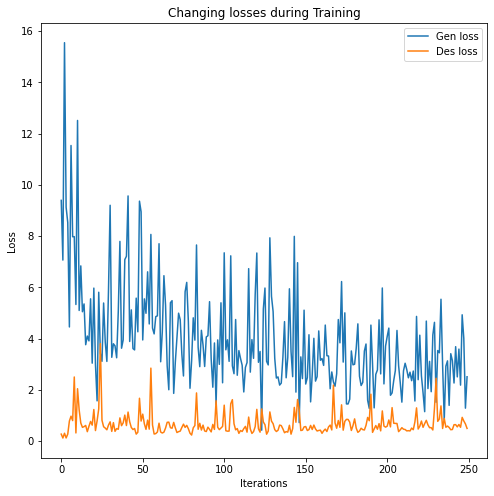

In [123]:
plt.figure(figsize=(8,8))
plt.title("Changing losses during Training")
plt.plot(g_losses, label="Gen loss")
plt.plot(d_losses, label="Des loss")
plt.xlabel("Iterations") 
plt.ylabel("Loss")
plt.legend()
plt.show()

We see that the losses are converging to a small values and this is good with 50 epochs ,we are good...

for observing the progression of the Gen we are going to create an animation based on images on the fake_images list 

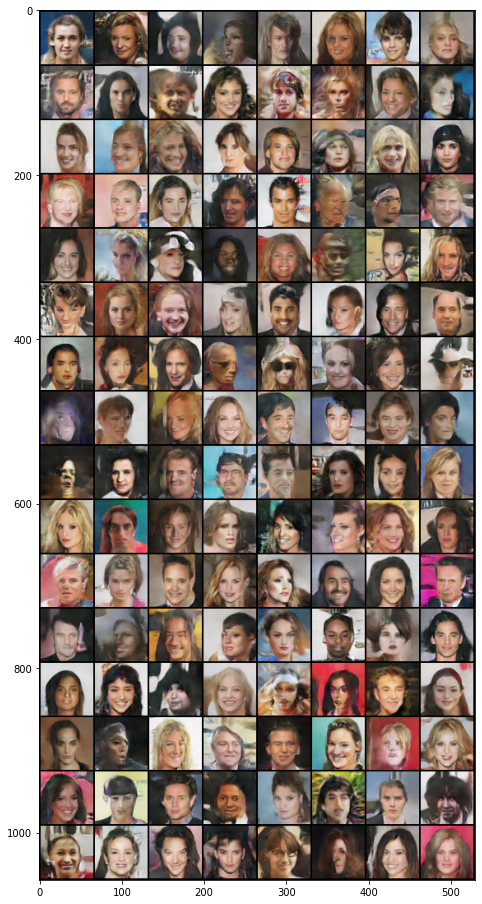

In [140]:
#ploting the generated batch of images (128 image as the latent vector size)
fig,ax = plt.subplots(figsize=(16,16))
ax.imshow(fake_images[240].permute(1,2,0))

now we will save all the generated images in a video so that we can see the progression of the Gen 

Visualizing the Real images


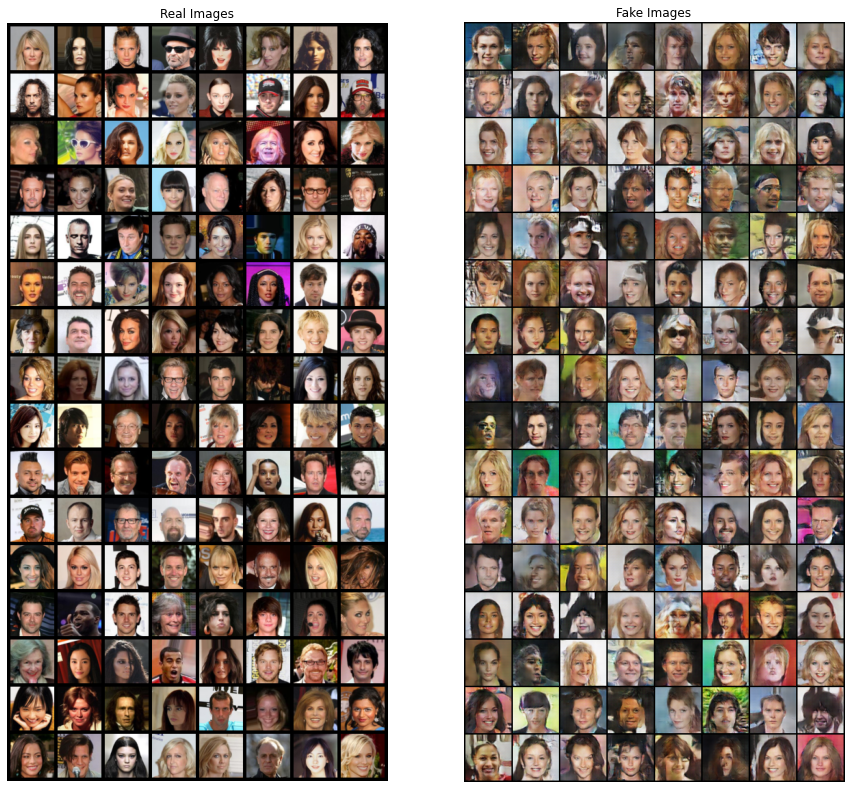

In [172]:
real_batch = None
for images,_ in dl : 
    real_batch = images
    break
    
print("Visualizing the Real images")
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:128],padding=5,normalize=True).cpu() ,(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_images[-1],(1,2,0)))
plt.show()


Finaly , we see that we have good results after comparing the real images with the generated ones.
as an extention we can try to add some layers into the Gen and Des to see if we will perform our DCGAN.

This was the end of the notebook, hoping you enjoyed reading it :) 
Don't even hesitate to contacte me if you have some questions or if you want to give me some advices or additions on the notebook. 

----------------------------------------------------------